# Cross validation

In [14]:
import os
import sys
from fitting import FitModel
import numpy as np
import matplotlib.pyplot as plt
import json
import glob

In [15]:
def get_forces(fit_data, values, args):
    fit_data.init_potential(values, args)
    ip_forces = fit_data.get_forces()
    dft_forces = fit_data.expected_forces()
    return dft_forces, ip_forces

def chi_squared_error(dft_forces, ip_forces):
    return np.sum((dft_forces - ip_forces)**2)/ dft_forces.size

def create_directory(head_directory_name, structure_number):
    directory = os.path.join(head_directory_name, str(structure_number))
    os.makedirs(directory)
    return directory

def validation_sets(num_of_fits, tot_num_structures, num_struct_to_fit, structure_nums):
    sets_of_structures = []
    while len(sets_of_structures) < num_of_fits:
        struct_set = np.sort(np.random.randint(1,tot_num_structures+1, size=num_struct_to_fit), axis=0)
        if len(set(struct_set)) != num_struct_to_fit:
            continue
        if any(x in struct_set for x in structure_nums):
            continue
        if not any(np.array_equiv(struct_set, x) for x in sets_of_structures):
            sets_of_structures.append(struct_set)
    return np.array(sets_of_structures)

### Set up parameters for LiNiO2 with core-shell O-O

In [16]:
params = {}
params['core_shell'] = { 'Li': False, 'Ni': False, 'O': True }
params['charges'] = {'Li': +1.0,
                     'Ni': +3.0,
                     'O': {'core':  -2.0, #+0.960,
                           'shell': 0.0}} #-2.960}}
params['masses'] = {'Li': 6.941,
                    'Ni': 58.6934,
                    'O': {'core': 14.3991,
                          'shell': 1.5999} }
params['cs_springs'] = {'O-O' : [20.0, 0.0]}

distribution = {}
distribution['Li-O'] = {'bpp' : [663.111, 0.119, 0.0],
                        'sd' : [80, 0.01, 0.01]}
distribution['Ni-O'] = {'bpp' : [1393.540, 0.218, 0.000],
                        'sd'  : [80, 0.01, 0.01]}
distribution['O-O'] = {'bpp' : [25804.807, 0.284, 0.0],
                       'sd'  : [200, 0.01, 5]}

### Define the directory paths and names/number of structures

In [17]:
# Define number of structures
tot_num_structures = 15 #Total number of structures in the pool
num_struct_to_fit = 4 #How many structures are in the fit
num_of_fits = 14 #How many validation sets to run

# Define paths to poscar/outcar directories
poscar_directory = os.path.join('poscars','thermos')
outcar_directory = os.path.join('outcars','thermos')

# Create cross validation directory
head_directory_name = '{}_structure_fits'.format(num_struct_to_fit)
cv_directory_name = 'cross_validation'
head_output_directory = create_directory(head_directory_name, cv_directory_name)

### Calculates each structures potential with every other structure, returning the forces and error

In [18]:
for potential_file in sorted(glob.glob('{}/*/potentials.json'.format(head_directory_name))):
    with open(potential_file, 'r') as f:
        potentials = json.load(f)
    structure_nums = potential_file.replace('/potentials.json', '').replace('{}/'.format(head_directory_name),'')
    structure_nums = np.array([int(num) for num in structure_nums.split('-')])
    include_labels = list(potentials.keys())
    include_values = list(potentials.values())
    indv_output_directory = create_directory(head_output_directory, 'p{}'.format('-'.join([str(num) for num in structure_nums])))
    sets_of_structures = validation_sets(num_of_fits, tot_num_structures, num_struct_to_fit, structure_nums)
    for structs in sets_of_structures: 
        for struct_num, struct in enumerate(structs):
            os.system('cp {}/POSCAR{} {}/POSCAR{}'.format(poscar_directory, struct, 'poscars', struct_num+1))
            os.system('cp {}/OUTCAR{} {}/OUTCAR{}'.format(outcar_directory, struct, 'outcars', struct_num+1))    
        fit_data = FitModel.collect_info(params, distribution, supercell=[2,2,2])
        dft_forces, ip_forces = get_forces(fit_data, include_values, include_labels)
        error = chi_squared_error(dft_forces, ip_forces)     
#         print('{}/p{}-s{}_dft_forces.dat'.format(indv_output_directory, ','.join([str(num) for num in structure_nums]), ','.join([str(num) for num in structs])))
        np.savetxt('{}/s{}_dft_forces.dat'.format(indv_output_directory, '-'.join([str(num) for num in structs])), dft_forces, fmt='%.10e', delimiter=' ')
        np.savetxt('{}/s{}_ip_forces.dat'.format(indv_output_directory, '-'.join([str(num) for num in structs])), ip_forces, fmt='%.10e', delimiter=' ')
        with open('{}/s{}_error.dat'.format(indv_output_directory, '-'.join([str(num) for num in structs])), 'w') as f:
            f.write(str(error)) 

Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements: ['Li', 'Ni', 'O']
Found elements

## Plotting the cross-validation

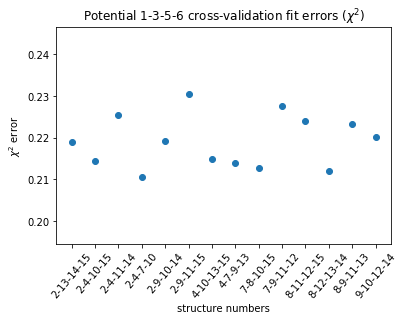

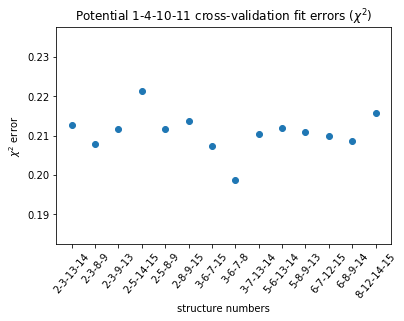

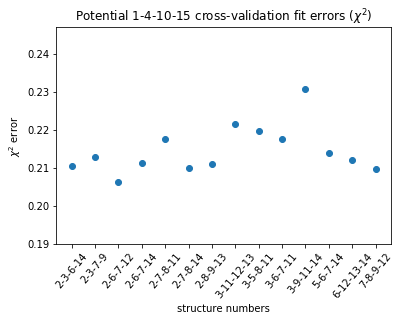

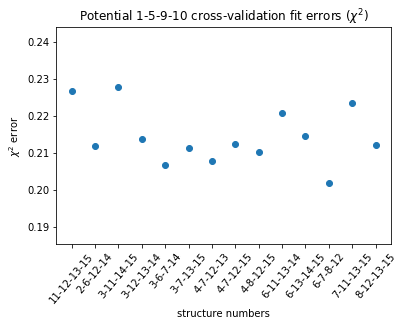

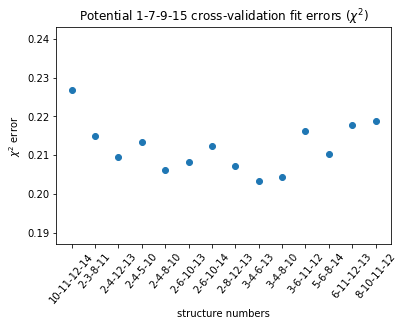

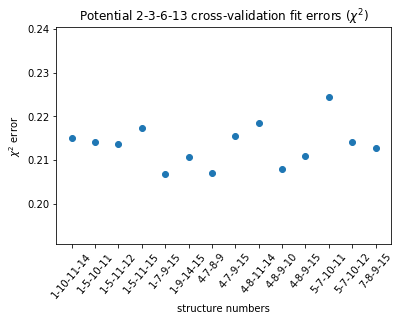

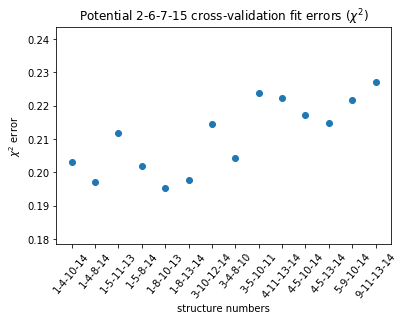

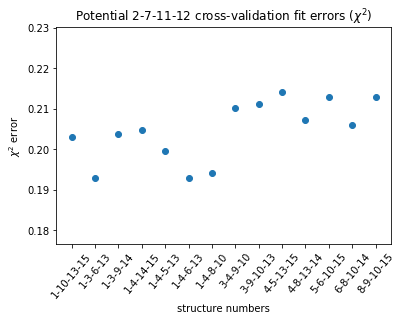

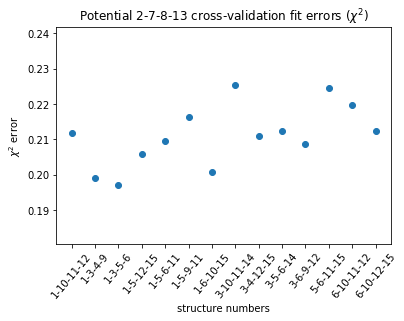

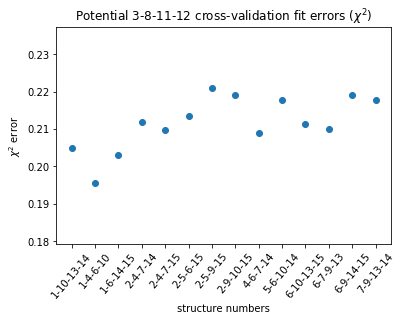

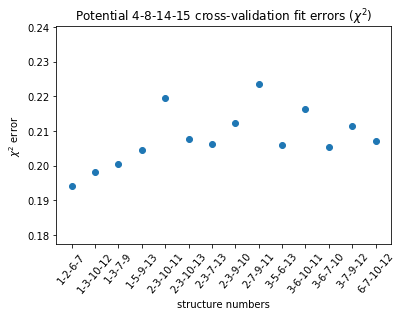

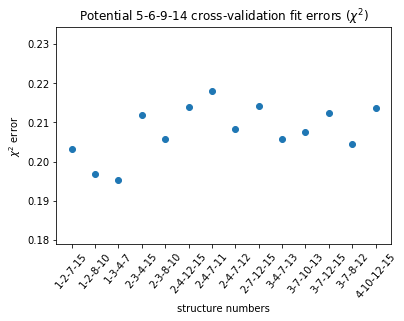

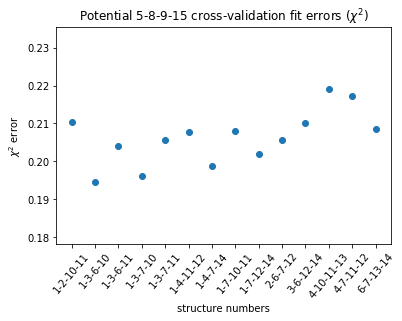

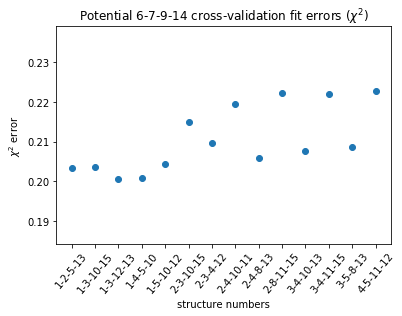

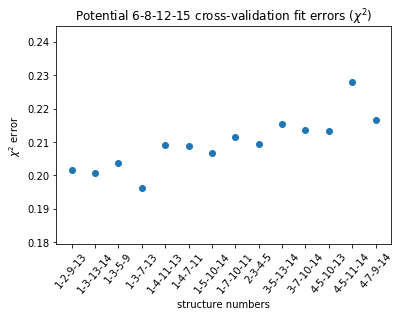

In [19]:
for cv_directory in sorted(glob.glob('{}/*'.format(head_output_directory))):
    if '.png' in cv_directory:
        continue
    error_dict = {}
    for error_file in sorted(glob.glob('{}/*error.dat'.format(cv_directory))):
        fit_struct_nums = error_file.replace(cv_directory, '').replace('/s','').replace('_error.dat', '')
        error = float(np.loadtxt(error_file))
        error_dict.update( {fit_struct_nums:error})
    plt.scatter(*zip(*sorted(error_dict.items())))
    plt.xticks(rotation=50)
    plt.xlabel('structure numbers')
    plt.ylabel('$\chi^2$ error')
    plt.title('Potential {} cross-validation fit errors ($\chi^2$)'.format(cv_directory.replace('{}/p'.format(head_output_directory),'')))
    plt.savefig('{}/p{}_cv_fit_errors.png'.format(head_output_directory,cv_directory.replace('{}/p'.format(head_output_directory),'')),dpi=500, bbox_inches = "tight")
    plt.show()